In [2]:
import ROOT as r
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
import os
sys.path.append(os.getcwd()+ '/../utilities/')
from milliqanProcessor import *
from milliqanScheduler import *
from milliqanCuts import *
from milliqanPlotter import *

In [3]:
newCalibrations = [-15.65, -15.45, -15.54, -14.14, -25.00, -20.61, -20.26, -18.80, 
                   -13.99, -14.42, -16.72, -16.20, -17.38, -23.36, -24.32, -19.14, 
                   -10.15, -11.64, -12.31, -13.35, -14.11, -18.87, -15.29, -14.54, 
                   0, 0, -6.10, -8.59, -9.66, -16.66, -15.18, -13.45, 
                   4.13, 2.57, 3.41, 3.32, 0.77, -3.34, -2.22, -4.28, 
                   5.23, 4.58, 1.29, 4.03, 0.49, -2.68, -3.21, -4.38, 
                   12.74, 11.98, 12.43, 12.50, 3.64, 7.24, 5.95, -2.35, 
                   11.92, 11.51, 6.50, 6.21, 1.64, 0.80, 1.44, -0.27, 
                   0, 0, 0, 0, 8.67, 25.98, 8.13, 18.82,
                   5.68, 10.21, 0, 16.54, 0, 0, -4.70, -7.77]

In [4]:
f_cal = open('../../configuration/barConfigs/configRun1296_present.json')
oldCalibrations = json.load(f_cal)['timingCalibrations']

newCalibrations = np.array(newCalibrations)
oldCalibrations = np.array(oldCalibrations)

In [5]:
diffs = oldCalibrations - newCalibrations
channels = np.arange(80)

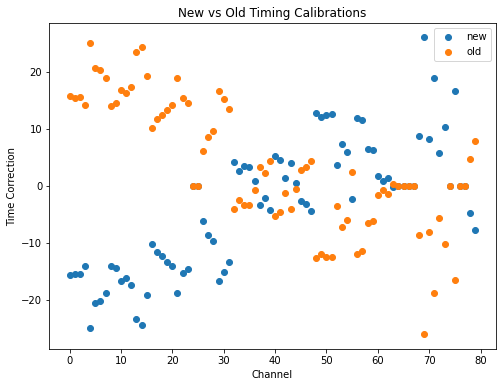

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(channels, newCalibrations, label='new')
plt.scatter(channels, oldCalibrations, label='old')
plt.title('New vs Old Timing Calibrations')
plt.xlabel('Channel')
plt.ylabel('Time Correction')
plt.legend()

Text(0, 0.5, 'Old - New Calibration')

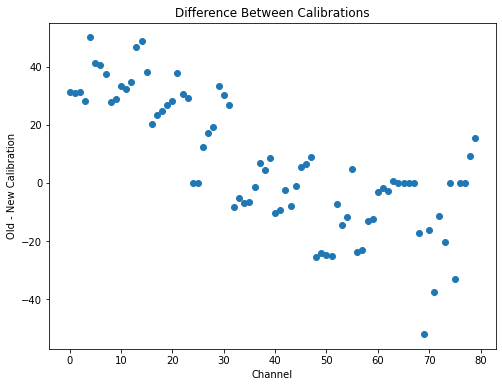

In [7]:
plt.figure(figsize=(8, 6))

plt.scatter(channels, diffs)
plt.title('Difference Between Calibrations')
plt.xlabel('Channel')
plt.ylabel('Old - New Calibration')

In [6]:
@mqCut
def timeDiffFrontPanel(self):

    frontPanelMask = ak.any(self.events['chan']==74, axis=1)
    backPanelMask = ak.any(self.events['chan']==75, axis=1)

    frontPanelMask = frontPanelMask & backPanelMask
    
    _, allTimesMask = ak.broadcast_arrays(self.events['timeFit'], frontPanelMask)
    allTimes = ak.mask(self.events['timeFit'], allTimesMask)
    allChannels = ak.mask(self.events['chan'], allTimesMask)
    allLayers = ak.mask(self.events['layer'], allTimesMask)
    
    frontPanelTimes = self.events['timeFit'][(self.events['chan'] == 74) & (frontPanelMask)]

    frontPanelTimes = ak.pad_none(frontPanelTimes, 1)
    frontPanelTimes = ak.flatten(frontPanelTimes)

    
    #print("front", len(frontPanelTimes), frontPanelTimes)
    #print("all", len(allTimes), allTimes)

    # Use ak.cartesian to match the structures
    #single_broadcasted = ak.zip({"single": frontPanelTimes, "multi": allTimes})
    
    # Expand the single_value array to match the structure of multiple_values
    #frontPanelTimes = ak.unzip(single_broadcasted)[0]

    timeDiffs = frontPanelTimes - allTimes
    #print(ak.drop_none(ak.flatten(timeDiffs)))

    allTimeCombos = ak.combinations(allTimes, 2)
    allLayerCombos = ak.combinations(allLayers, 2)
    #maxLayer = ak.argmax(allLayerCombos, axis=-1)
    allTimeDiffs = ak.where(allLayerCombos['0'] > allLayerCombos['1'], allTimeCombos['0']-allTimeCombos['1'], allTimeCombos['1']-allTimeCombos['0'])
    #print("All Time Differences:", allTimeDiffs)

    #print('sidebandRMS', len(self.events['sidebandRMS']), len(self.events['sidebandRMS'][0]))
    _, newCals = ak.broadcast_arrays(self.events['sidebandRMS'], ak.Array([newCalibrations]))
    _, oldCals = ak.broadcast_arrays(self.events['sidebandRMS'], ak.Array([oldCalibrations]))

    allTimesNew = allTimes - newCals[allChannels]
    timeDiffsNew = frontPanelTimes - allTimesNew
    allTimeCombosNew = ak.combinations(allTimesNew, 2)
    allTimeDiffsNew = ak.where(allLayerCombos['0'] > allLayerCombos['1'], allTimeCombosNew['0']-allTimeCombosNew['1'], allTimeCombosNew['1']-allTimeCombosNew['0'])

    allTimesOld = allTimes + oldCals[allChannels]
    timeDiffsOld = frontPanelTimes - allTimesOld
    allTimeCombosOld = ak.combinations(allTimesOld, 2)
    allTimeDiffsOld = ak.where(allLayerCombos['0'] > allLayerCombos['1'], allTimeCombosOld['0']-allTimeCombosOld['1'], allTimeCombosOld['1']-allTimeCombosOld['0'])

    self.events['timeDiff'] = timeDiffs
    self.events['timeDiffNewCorrected'] = timeDiffsNew
    self.events['timeDiffOldCorrected'] = timeDiffsOld
    self.events['allTimeDiffs'] = allTimeDiffs
    self.events['allTimeDiffsNew'] = allTimeDiffsNew
    self.events['allTimeDiffsOld'] = allTimeDiffsOld
    

@mqCut
def frontPanelMask(self, cutName='frontPanelMask', cut=False, branches=None):

    frontPanelMask = ak.any(self.events['chan'] == 74, axis=1)
    _, frontPanelMask = ak.broadcast_arrays(self.events['npulses'], frontPanelMask)

    self.events[cutName] = frontPanelMask
    
    if cut:
        self.cutBranches(branches, cutName)

@mqCut
def backPanelMask(self, cutName='backPanelMask', cut=False, branches=None):

    frontPanelMask = ak.any(self.events['chan'] == 75, axis=1)
    _, frontPanelMask = ak.broadcast_arrays(self.events['npulses'], frontPanelMask)

    self.events[cutName] = frontPanelMask
    
    if cut:
        self.cutBranches(branches, cutName)

In [7]:
if __name__ == "__main__":

    filelist = [
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1400_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1500_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1600_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1700_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root',
        '/eos/experiment/milliqan/skims/beam/MilliQan_Run1900_v35_beam_beamOn_tight.root',
    ]

    print("Running on files {}".format(filelist))

    #define the necessary branches to run over
    branches = ['event', 'tTrigger', 'boardsMatched', 'pickupFlag', 'pickupFlagTight', 'fileNumber', 'runNumber', 'type', 'ipulse', 'nPE', 'chan',
                'time_module_calibrated', 'timeFit_module_calibrated', 'row', 'column', 'layer', 'height', 'area', 'npulses', 'timeFit', 'sidebandRMS']


    #define the milliqan cuts object
    mycuts = milliqanCuts()

    setattr(milliqanCuts, "timeDiffFrontPanel", timeDiffFrontPanel)
    setattr(milliqanCuts, 'frontPanelMask', frontPanelMask)
    setattr(milliqanCuts, 'backPanelMask', backPanelMask)
    
    #require pulses are not pickup
    pickupCut = getCutMod(mycuts.pickupCut, mycuts, 'pickupCut', tight=True, cut=True, branches=branches)

    #require that all digitizer boards are matched
    boardMatchCut = getCutMod(mycuts.boardsMatched, mycuts, 'boardMatchCut', cut=True, branches=branches)

    #greater than or equal to one hit per layer
    hitInAllLayers = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'hitInAllLayers', cut=True, branches=branches, multipleHits=False)

    #exactly one hit per layer
    oneHitPerLayer = getCutMod(mycuts.oneHitPerLayerCut, mycuts, 'oneHitPerLayer', cut=True, branches=branches, multipleHits=False)

    #four layer cut
    fourLayerCut = getCutMod(mycuts.fourLayerCut, mycuts, 'fourLayerCut', cut=True, branches=branches)

    #panel veto
    panelVeto = getCutMod(mycuts.panelVeto, mycuts, 'panelVeto', nPECut=40e3, cut=True, branches=branches)

    #nPE Cut
    nPECut = getCutMod(mycuts.nPECut, mycuts, 'nPECut', nPECut=100, cut=True, branches=branches)

    #area cut
    areaCut = getCutMod(mycuts.areaCut, mycuts, 'areaCut', areaCut=300000, cut=True, branches=branches)

    #first pulse cut
    firstPulseCut = getCutMod(mycuts.firstPulseCut, mycuts, 'firstPulseCut', cut=True, branches=branches)

    #require front panel has hit
    #frontPanelHit = getCutMod(mycuts.frontPanelHit, mycuts, 'frontPanelHit', cut=True, branches=branches)

    #require hit time is in trigger window
    centralTime = getCutMod(mycuts.centralTime, mycuts, 'centralTime', cut=True, branches=branches)

    straightLineCut = getCutMod(mycuts.straightLineCut, mycuts, 'straightLineCut', cut=True, branches=branches)
    threeLineCut = getCutMod(mycuts.threeInLine, mycuts, 'threeInLine', cut=True, pulseCut=False, branches=branches)

    frontPanelMask = getCutMod(mycuts.frontPanelMask, mycuts, 'frontPanelMask', cut=True, branches=branches)
    backPanelMask = getCutMod(mycuts.backPanelMask, mycuts, 'backPanelMask', cut=True, branches=branches)

    nbins = 100
    minx = -10
    maxx = 90
    
    h_timeDiffWide = r.TH2F('h_timeDiffWide', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiff = r.TH2F('h_timeDiff', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -10, 10)
    h_timeDiffNew = r.TH2F('h_timeDiffNew', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffOld = r.TH2F('h_timeDiffOld', 'Timing Difference from Front Panel;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffAll = r.TH2F('h_timeDiffAll', 'Timing Difference All Channels;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffAllNew = r.TH2F('h_timeDiffAllNew', 'Timing Difference All Channels;Channel;dT', 100, -10, 90, 100, -50, 50)
    h_timeDiffAllOld = r.TH2F('h_timeDiffAllOld', 'Timing Difference All Channels;Channel;dT', 100, -10, 90, 100, -50, 50)


    cutflow = [mycuts.totalEventCounter, mycuts.fullEventCounter, 
                boardMatchCut, 
                pickupCut, 
                firstPulseCut,
                nPECut,
                centralTime,
                #straightLineCut,
                threeLineCut, 
                frontPanelMask,
                backPanelMask,
                mycuts.timeDiffFrontPanel,
                #fourLayerCut,
                #frontPanelHit,
                #mycuts.straightLineCut, 
                #mycuts.pulseTime,
                #mycuts.threeInLine,
                #mycuts.timeDiff,
                #mycuts.getTimeDiffs
            ]
    
    #define milliqan plotter
    myplotter = milliqanPlotter()
    myplotter.dict.clear()

    #myplotter.addHistograms(h_channels, 'chan')
    #myplotter.addHistograms(h_timeDiff, 'timeDiff')
    #myplotter.addHistograms(h_timeDiffNoCorr, 'timeDiffNoCorr')
    #myplotter.addHistograms(h_timeDiffOld, 'timeDiffOld')

    myplotter.addHistograms(h_timeDiff, ['chan', 'timeDiff'])
    myplotter.addHistograms(h_timeDiffWide, ['chan', 'timeDiff'])
    myplotter.addHistograms(h_timeDiffNew, ['chan', 'timeDiffNewCorrected'])
    myplotter.addHistograms(h_timeDiffOld, ['chan', 'timeDiffOldCorrected'])
    myplotter.addHistograms(h_timeDiffAll, ['chan', 'allTimeDiffs'])
    myplotter.addHistograms(h_timeDiffAllNew, ['chan', 'allTimeDiffsNew'])
    myplotter.addHistograms(h_timeDiffAllOld, ['chan', 'allTimeDiffsOld'])

    for key, value in myplotter.dict.items():
        if value not in cutflow:
            cutflow.append(value)

    #create a schedule of the cuts
    myschedule = milliQanScheduler(cutflow, mycuts, myplotter)

    #print out the schedule
    myschedule.printSchedule()

    #create the milliqan processor object
    myiterator = milliqanProcessor(filelist, branches, myschedule, step_size=10000, qualityLevel='override')

    #run the milliqan processor
    myiterator.run()

    myschedule.cutFlowPlots()

    #save plots
    myplotter.saveHistograms("timingCorrectionCheckBothPanels.root")

    mycuts.getCutflowCounts()


Running on files ['/eos/experiment/milliqan/skims/beam/MilliQan_Run1400_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1500_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1600_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1700_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root', '/eos/experiment/milliqan/skims/beam/MilliQan_Run1900_v35_beam_beamOn_tight.root']
----------------------------
MilliQan Scheduler:
	0. totalEventCounter
	1. fullEventCounter
	2. boardMatchCut
	3. pickupCut
	4. firstPulseCut
	5. nPECut
	6. centralTime
	7. threeInLine
	8. frontPanelMask
	9. backPanelMask
	10. timeDiffFrontPanel
	11. h_timeDiff
	12. h_timeDiffWide
	13. h_timeDiffNew
	14. h_timeDiffOld
	15. h_timeDiffAll
	16. h_timeDiffAllNew
	17. h_timeDiffAllOld
----------------------------

Chosen quality level:  override 
Chosen verbosity level:  minimal 


Qu

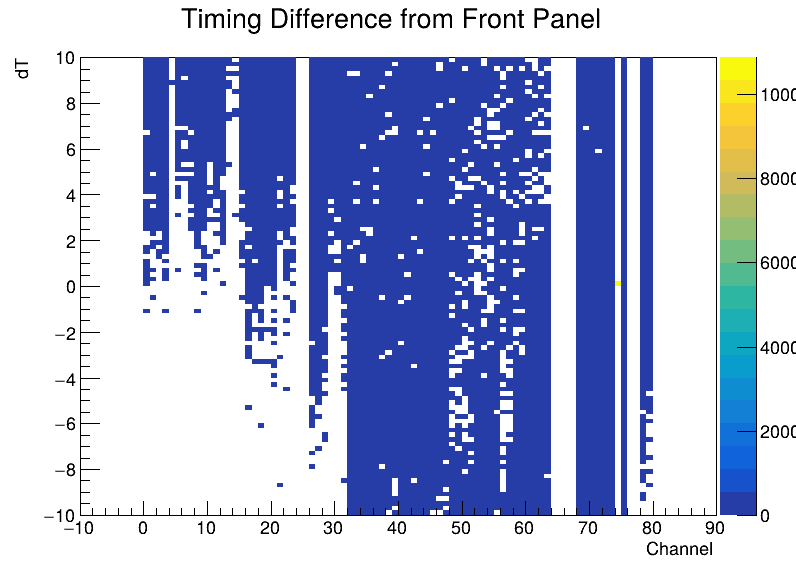

In [10]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiff.Draw('colz')
c1.Draw()

In [11]:
h_timeDiffWide.Integral(0, 100, 0, 100)

133860.0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


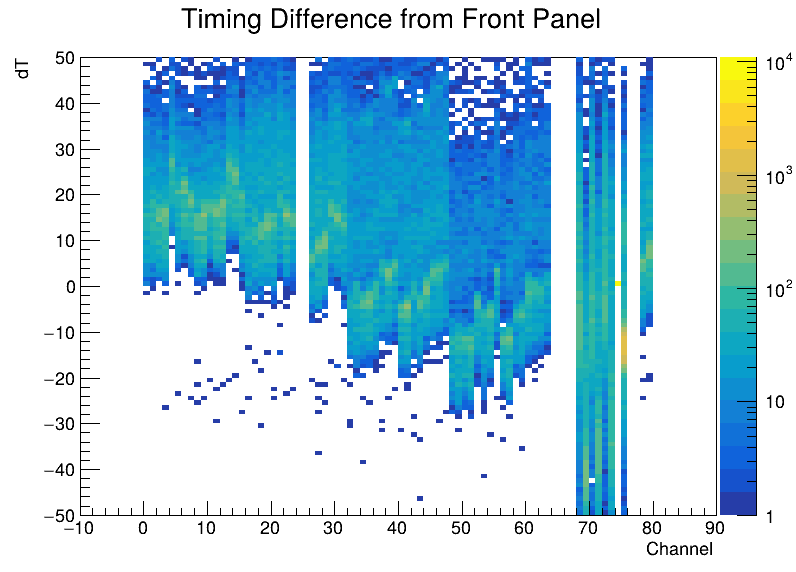

In [12]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffWide.Draw('colz')
c1.Draw()
c1.SetLogz(1)

In [2]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffNew.Draw('colz')
c1.Draw()
c1.SetLogz(1)

NameError: name 'h_timeDiffNew' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


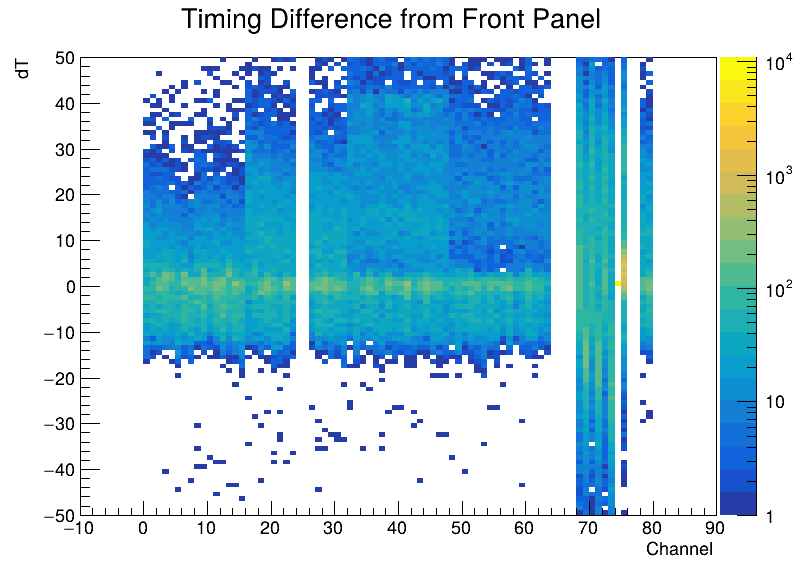

In [14]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffOld.Draw('colz')
c1.Draw()
c1.SetLogz()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


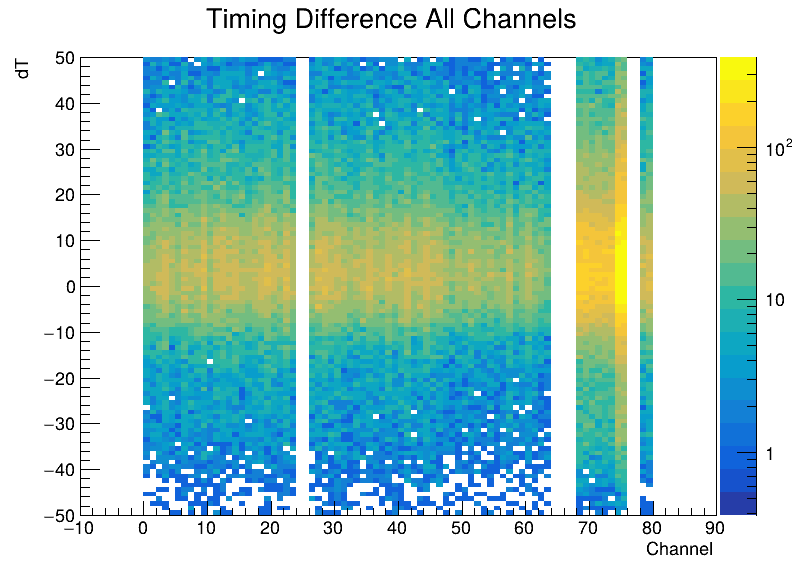

In [15]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffAll.Draw('colz')
c1.Draw()
c1.SetLogz(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


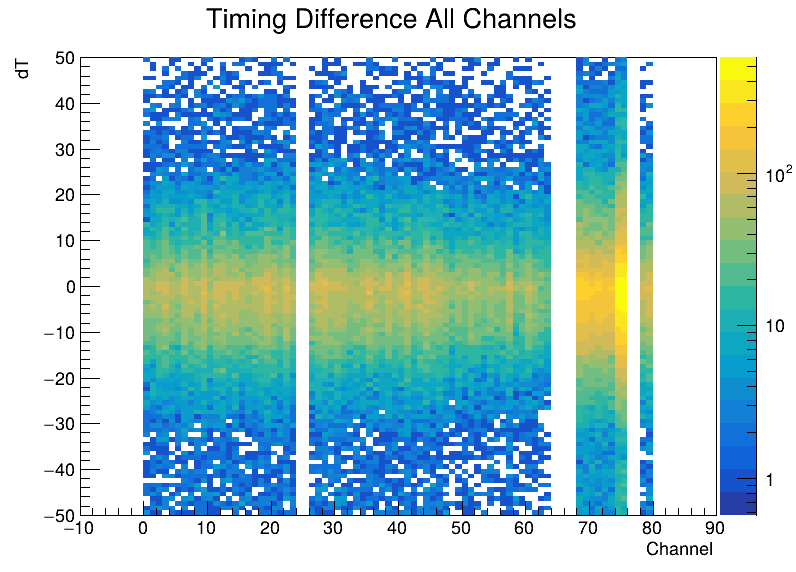

In [16]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffAllNew.Draw('colz')
c1.Draw()
c1.SetLogz(1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


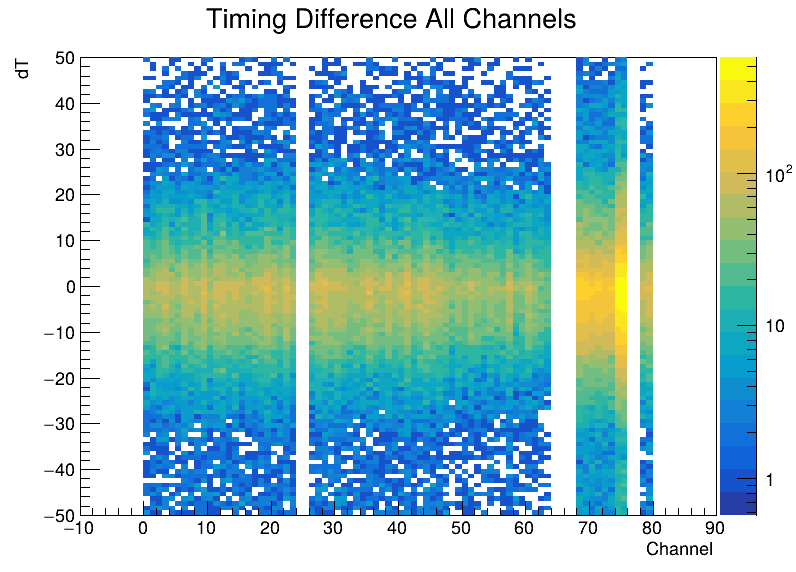

In [17]:
r.gStyle.SetOptStat(0)
c1 = r.TCanvas('c1', 'c1', 800, 600)
c1.cd()
h_timeDiffAllOld.Draw('colz')
c1.Draw()
c1.SetLogz()

In [18]:
fin = r.TFile.Open('/eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root')
mytree = fin.Get('t')
c1 = r.TCanvas("c1", "c1", 800, 600)
fin.ls()

TNetXNGFile**		root://eospublic.cern.ch//eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root	
 TNetXNGFile*		root://eospublic.cern.ch//eos/experiment/milliqan/skims/zeroBias/MilliQan_Run1800_v35_zeroBias_beamOff_tight.root	
  OBJ: TTree	t	t : 0 at: 0xee54370
  KEY: TTree	t;2	t [current cycle]
  KEY: TTree	t;1	t [backup cycle]
  KEY: TNamed	luminosity;1	0.0
  KEY: TNamed	runTime;1	228916.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [234]:
fin = r.TFile.Open('timingCalibrationPlots.root', 'READ')

l1 = fin.Get('FitsL1')
l2 = fin.Get('FitsL2')
l3 = fin.Get('FitsL3')
l4 = fin.Get('FitsL4')

savedHists = []
savedFits = []

for i, obj in enumerate(l1.GetListOfPrimitives()):
    #print(obj.GetName(), obj.ClassName())
    obj.SetMargin(0.15, 0.15, 0.15, 0.15)
    for j, obj2 in enumerate(obj.GetListOfPrimitives()):
        #print(obj2.GetName(), obj2.ClassName())
        if isinstance(obj2, r.TF1):
            obj2.SetLineColor(r.kRed)
            if i==10:
                print("fit 10")
                savedFits.append(obj2)
        if not isinstance(obj2, r.TH1): continue
        obj2.SetTitle(f'Channel {i};#DeltaT(front panel, chan) [ns];Pulses')
        if i==2:
            obj2.GetYaxis().SetRangeUser(0, 14000)
        if i==10:
            savedHists.append(obj2)

for i, obj in enumerate(l2.GetListOfPrimitives()):
    obj.SetMargin(0.15, 0.15, 0.15, 0.15)
    for j, obj2 in enumerate(obj.GetListOfPrimitives()):
        if isinstance(obj2, r.TF1):
            obj2.SetLineColor(r.kRed)
            if i+16==26:
                print("fit 26")
                savedFits.append(obj2)
        if not isinstance(obj2, r.TH1): continue
        obj2.SetTitle(f'Channel {i+16};#DeltaT(front panel, chan) [ns];Pulses')
        if i+16==26:
            savedHists.append(obj2)

for i, obj in enumerate(l3.GetListOfPrimitives()):
    obj.SetMargin(0.15, 0.15, 0.15, 0.15)
    for j, obj2 in enumerate(obj.GetListOfPrimitives()):
        if isinstance(obj2, r.TF1):
            obj2.SetLineColor(r.kRed)
            if i+32==42:
                print("fit 42")
                savedFits.append(obj2)
        if not isinstance(obj2, r.TH1): continue
        obj2.SetTitle(f'Channel {i+32};#DeltaT(front panel, chan) [ns];Pulses')
        if i+32 == 44:
            obj2.GetYaxis().SetRangeUser(0, 18e3)
        if i +32 == 36:
            obj2.GetYaxis().SetRangeUser(0, 16e3)
        if i+32 == 42:
            savedHists.append(obj2)

            

for i, obj in enumerate(l4.GetListOfPrimitives()):
    obj.SetMargin(0.15, 0.15, 0.15, 0.15)
    for j, obj2 in enumerate(obj.GetListOfPrimitives()):
        if isinstance(obj2, r.TF1):
            obj2.SetLineColor(r.kRed)
            if i+48==58:
                print("fit 58")
                savedFits.append(obj2)
        if not isinstance(obj2, r.TH1): continue
        obj2.SetTitle(f'Channel {i+48};#DeltaT(front panel, chan) [ns];Pulses')
        if i+48 == 58:
            savedHists.append(obj2)

len(savedFits)

fit 10
fit 26
fit 42
fit 58


4

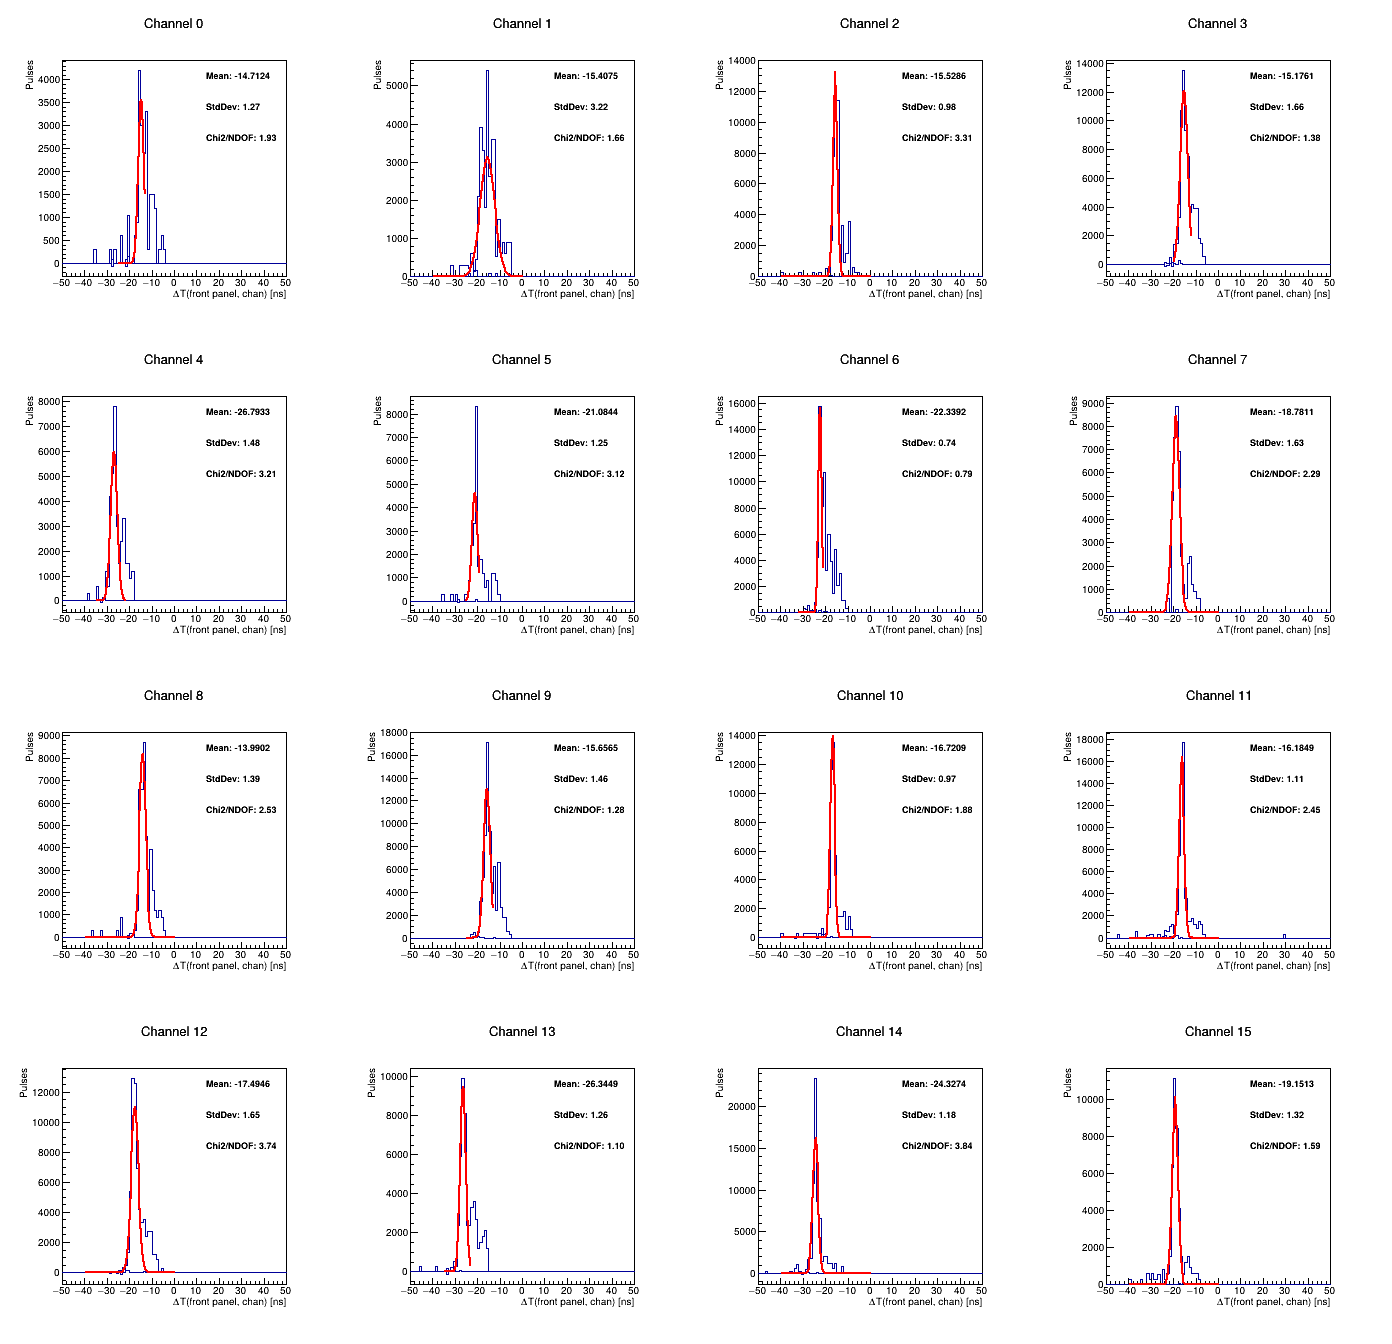

In [212]:
l1.Draw()

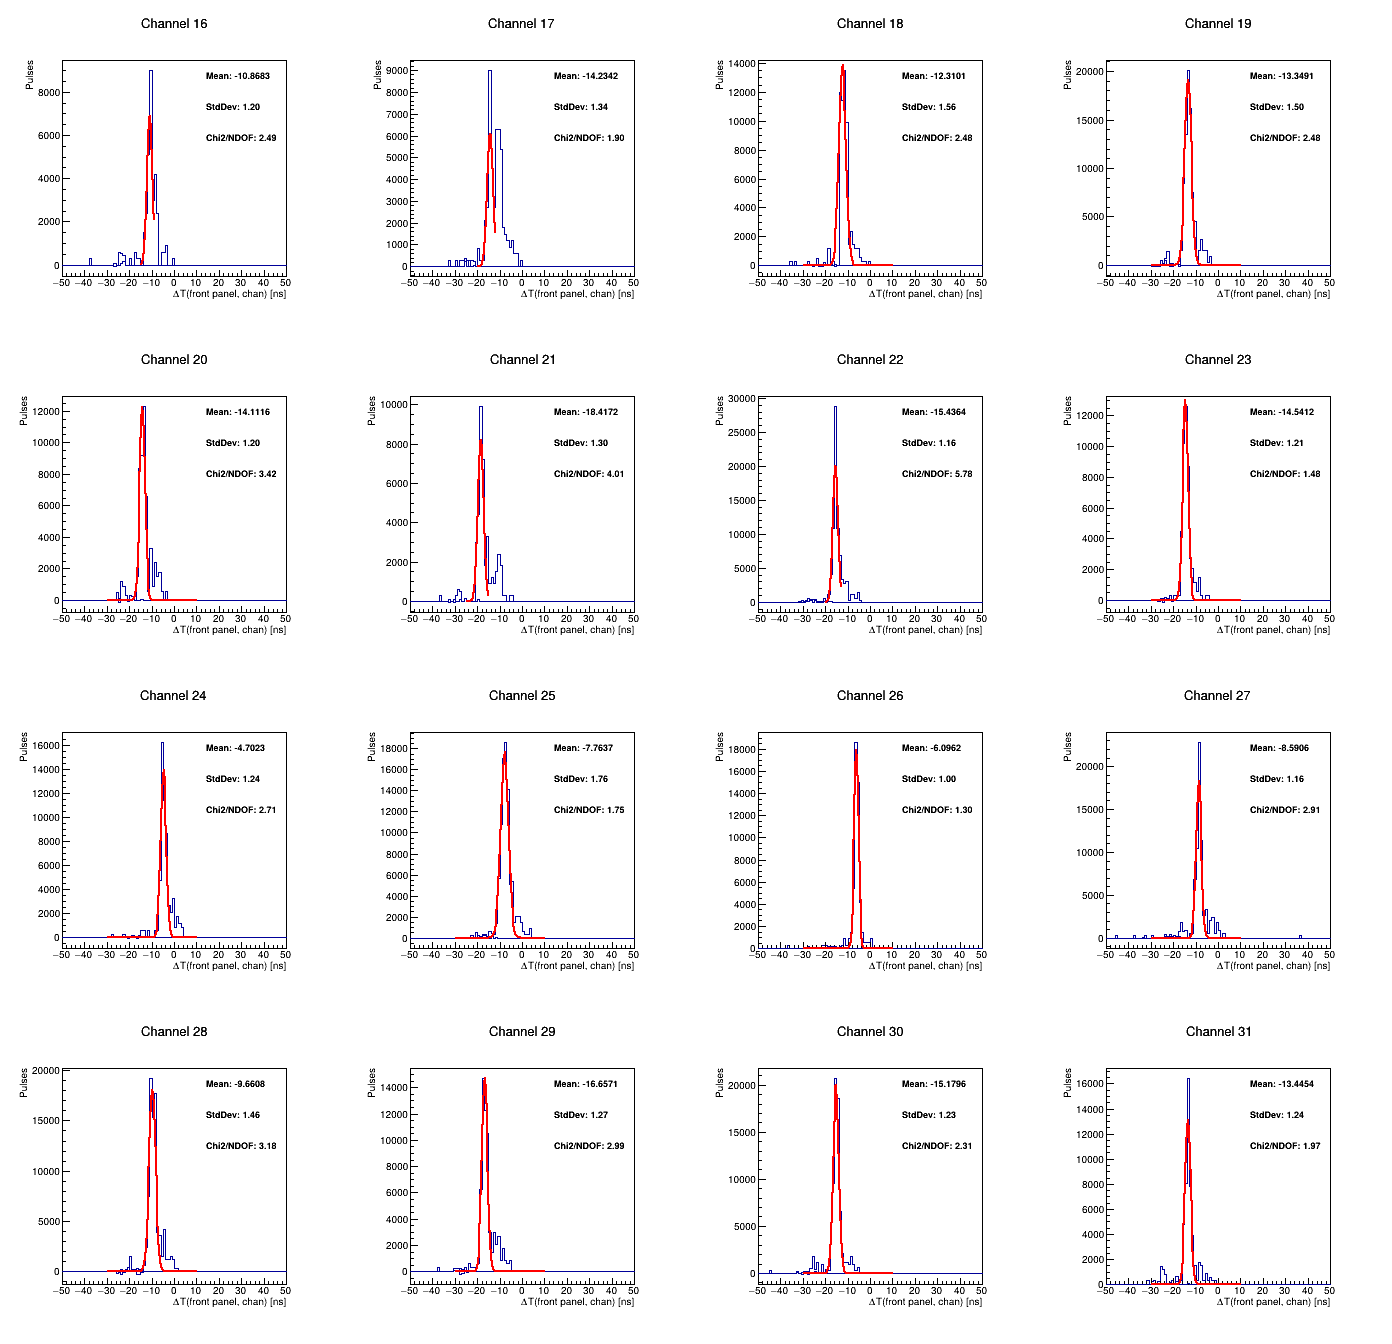

In [213]:
l2.Draw()

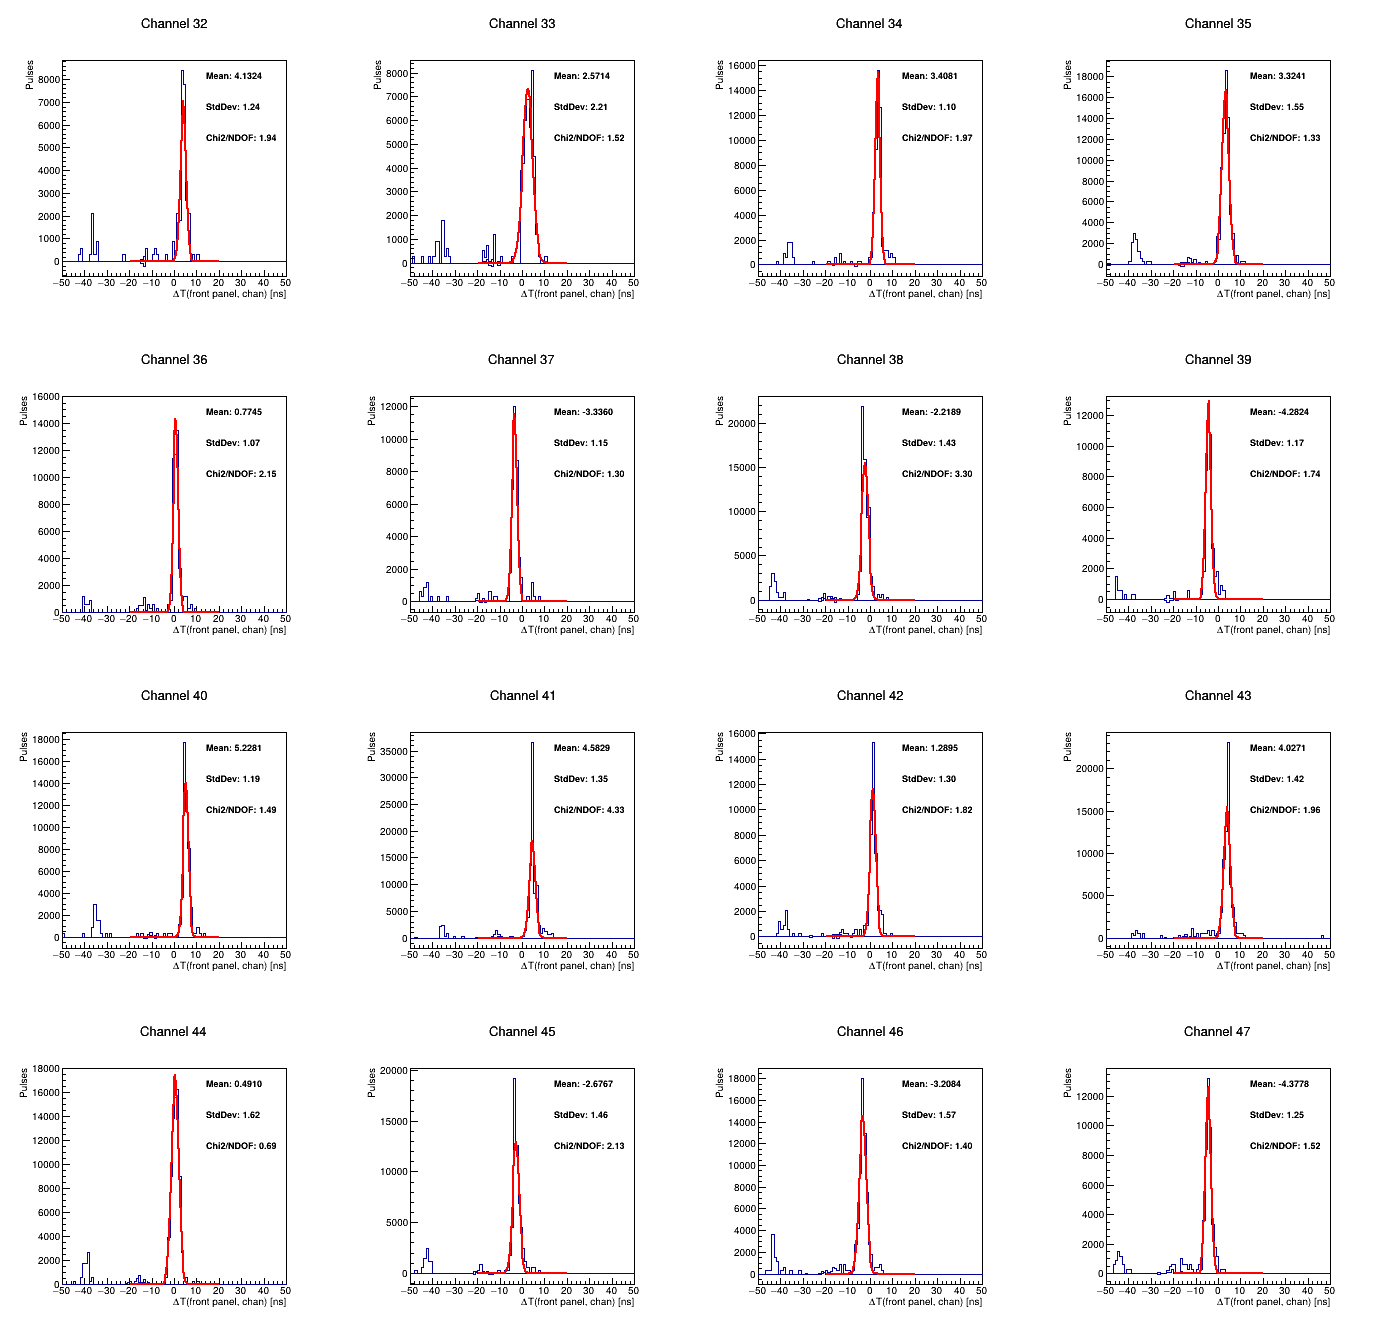

In [214]:
l3.Draw()

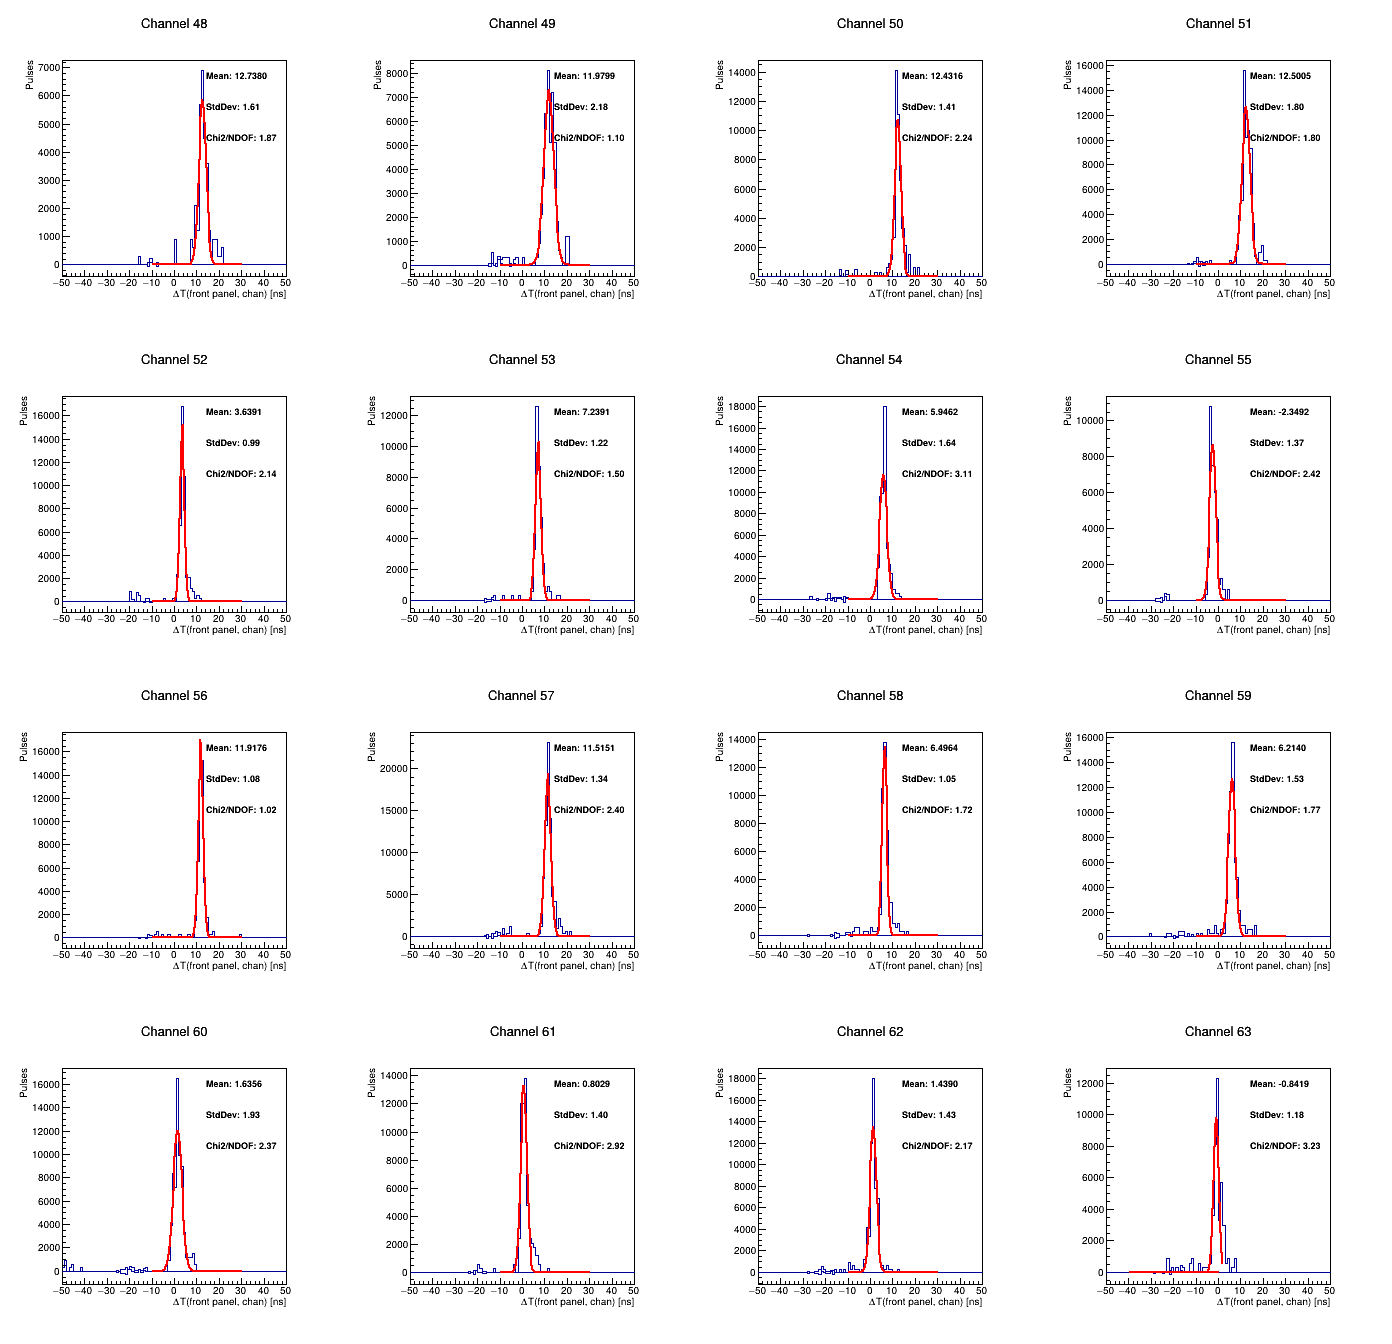

In [215]:
l4.Draw()

In [216]:
l1.SaveAs('layer1TimingCalibrations.png')
l2.SaveAs('layer2TimingCalibrations.png')
l3.SaveAs('layer3TimingCalibrations.png')
l4.SaveAs('layer4TimingCalibrations.png')

Info in <TCanvas::Print>: png file layer1TimingCalibrations.png has been created
Info in <TCanvas::Print>: png file layer2TimingCalibrations.png has been created
Info in <TCanvas::Print>: png file layer3TimingCalibrations.png has been created
Info in <TCanvas::Print>: png file layer4TimingCalibrations.png has been created


In [235]:
#c1 = r.TCanvas("c1", "c1", 800, 600)
hists = savedHists[::2]
fits = savedFits
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(0)

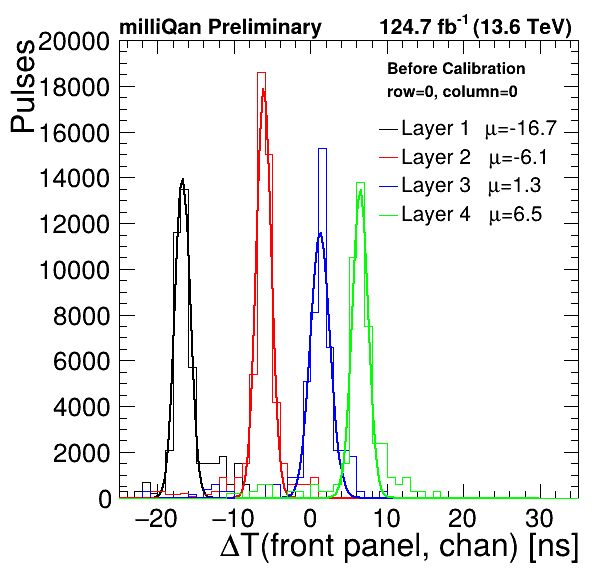

In [237]:
hists[0].SetTitle(';#DeltaT(front panel, chan) [ns]')
hists[0].GetYaxis().SetTitleOffset(1.7)
hists[0].SetLineColor(r.kBlack)
fits[0].SetLineColor(r.kBlack)
hists[0].Draw('hist')
fits[0].Draw("same")
hists[0].GetYaxis().SetRangeUser(0, 20000)
hists[0].GetXaxis().SetRangeUser(-25, 35)
hists[1].SetLineColor(r.kRed)
fits[1].SetLineColor(r.kRed)
fits[1].Draw("same")
hists[1].Draw("same hist")
hists[2].SetLineColor(r.kBlue)
fits[2].SetLineColor(r.kBlue)
hists[2].Draw("same hist")
fits[2].Draw("same")
hists[3].SetLineColor(r.kGreen)
fits[3].SetLineColor(r.kGreen)
fits[3].Draw("same")
hists[3].Draw("same hist")

l1 = r.TLegend(0.63, 0.6, 0.8, 0.8)
l1.AddEntry(hists[0], 'Layer 1 #mu=-16.7', 'l')
l1.AddEntry(hists[1], 'Layer 2 #mu=-6.1', 'l')
l1.AddEntry(hists[2], 'Layer 3 #mu=1.3', 'l')
l1.AddEntry(hists[3], 'Layer 4 #mu=6.5', 'l')
l1.SetLineWidth(0)
6
l1.Draw()

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.2, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.96, 0.94, "124.7 fb^{-1} (13.6 TeV)");

info = r.TLatex()
info.SetTextSize(0.03)
info.DrawLatexNDC(0.65, 0.83, 'row=0, column=0')

cal = r.TLatex()
cal.SetTextSize(0.03)
cal.DrawLatexNDC(0.65, 0.87, 'Before Calibration')

#r.gPad.SetMargin(0.1, 0.05, 0.15, 0.05)
r.gPad.SetLeftMargin(0.2)
c1.Draw()


In [238]:
c1.SaveAs('plots/timingExampleUncalibrated.png')

Info in <TCanvas::Print>: png file plots/timingExampleUncalibrated.png has been created


In [231]:
hists = savedHists[::2]
fits = savedFits

binWidth = hists[0].GetXaxis().GetBinWidth(1)

h0 = r.TH1F('h0', '', hists[0].GetNbinsX(), hists[0].GetBinLowEdge(0), hists[0].GetXaxis().GetXmax())
h1 = r.TH1F('h1', '', hists[0].GetNbinsX(), hists[0].GetBinLowEdge(0), hists[0].GetXaxis().GetXmax())
h2 = r.TH1F('h2', '', hists[0].GetNbinsX(), hists[0].GetBinLowEdge(0), hists[0].GetXaxis().GetXmax())
h3 = r.TH1F('h3', '', hists[0].GetNbinsX(), hists[0].GetBinLowEdge(0), hists[0].GetXaxis().GetXmax())

hCorr = [h0, h1, h2, h3]
corrections = [16.7, 6.1, -1.3, -6.5] 
binCorr = [x/binWidth for x in corrections]

fitsCorr = fits
for i, x in enumerate(fitsCorr):
    x.SetParameter(1, x.GetParameter(1)+corrections[i])
    
for i, hist in enumerate(hists):
    for ibin in range(hist.GetNbinsX()):
        hCorr[i].SetBinContent(ibin+round(binCorr[i]), hist.GetBinContent(ibin))

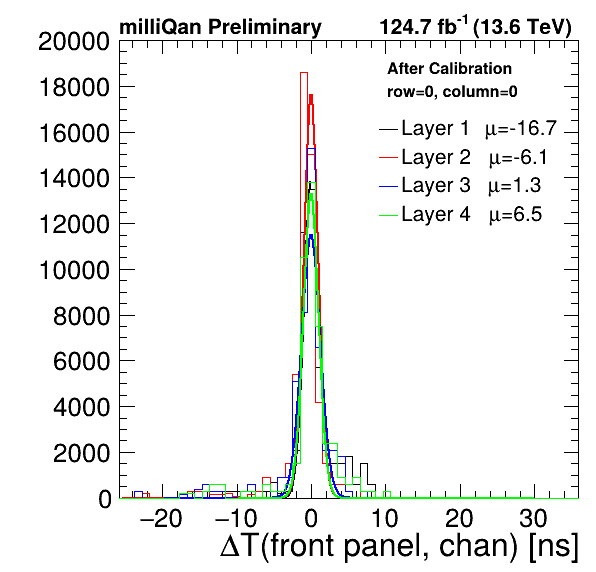

In [232]:
c1.Clear()
hCorr[0].GetYaxis().SetRangeUser(0, 20000)
hCorr[0].GetXaxis().SetRangeUser(-25, 25)
hCorr[0].SetTitle(';#DeltaT(front panel, chan) [ns]')
hCorr[0].GetYaxis().SetTitleOffset(1.7)
hCorr[0].SetLineColor(r.kBlack)
fitsCorr[0].SetLineColor(r.kBlack)
hCorr[0].Draw('hist')
fitsCorr[0].Draw("same")
hCorr[0].GetYaxis().SetRangeUser(0, 20000)
hCorr[0].GetXaxis().SetRangeUser(-25, 35)
hCorr[1].SetLineColor(r.kRed)
fitsCorr[1].SetLineColor(r.kRed)
fitsCorr[1].Draw("same")
hCorr[1].Draw("same hist")
hCorr[2].SetLineColor(r.kBlue)
fitsCorr[2].SetLineColor(r.kBlue)
hCorr[2].Draw("same hist")
fitsCorr[2].Draw("same")
hCorr[3].SetLineColor(r.kGreen)
fitsCorr[3].SetLineColor(r.kGreen)
fitsCorr[3].Draw("same")
hCorr[3].Draw("same hist")

l1 = r.TLegend(0.63, 0.6, 0.8, 0.8)
l1.AddEntry(hCorr[0], 'Layer 1 #mu=-16.7', 'l')
l1.AddEntry(hCorr[1], 'Layer 2 #mu=-6.1', 'l')
l1.AddEntry(hCorr[2], 'Layer 3 #mu=1.3', 'l')
l1.AddEntry(hCorr[3], 'Layer 4 #mu=6.5', 'l')
l1.SetLineWidth(0)
6
l1.Draw()

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.2, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.96, 0.94, "124.7 fb^{-1} (13.6 TeV)");

info = r.TLatex()
info.SetTextSize(0.03)
info.DrawLatexNDC(0.65, 0.83, 'row=0, column=0')

cal = r.TLatex()
cal.SetTextSize(0.03)
cal.DrawLatexNDC(0.65, 0.87, 'After Calibration')

#r.gPad.SetMargin(0.1, 0.05, 0.15, 0.05)
r.gPad.SetLeftMargin(0.2)
c1.Draw()


In [233]:
c1.SaveAs('plots/timingExampleCalibrated.png')

Info in <TCanvas::Print>: png file plots/timingExampleCalibrated.png has been created


### Plot timing difference between cosmic and beam muons

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3011] Unable to open file /eos/user/m/micarrig/milliqanOffline/Run3Detector/analysis/backgroundEstimation/beamMuonArea_beamOn_300kDebug.root; No such file or directory



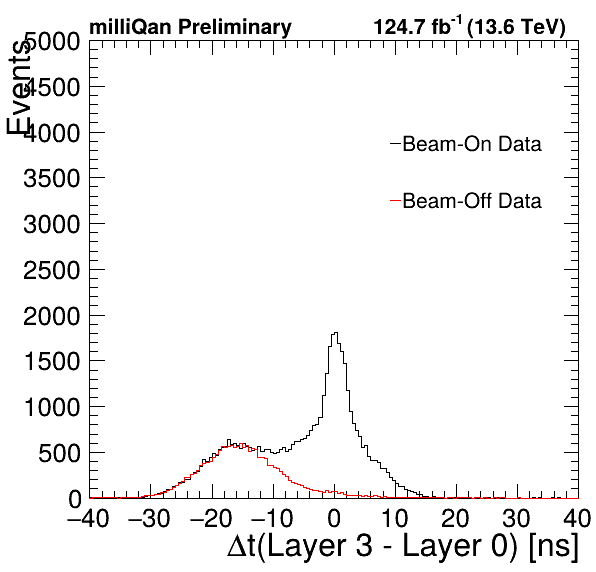

In [10]:
import cmsstyle as cms

#c1 = r.TCanvas("c1", "c1", 800, 600)

c1 = cms.cmsCanvas('c1',1e-1,40,2e-2,3e-1,"Mass [GeV]","Charge (Q/e)",iPos=0, square=True)


f_beam = r.TFile.Open('../backgroundEstimation/beamMuonRate_on300AllBars.root')
f_cosmic = r.TFile.Open('../backgroundEstimation/beamMuonRate_off300AllBars.root')

beamOffTime = 16096891
beamOnTime = 12214771

area=300
c1.Draw()

In [13]:
r.gStyle.SetOptFit(0)

t_beam = f_beam.Get('h_timeDiffL30')
t_cosmic = f_cosmic.Get('h_timeDiffL30')

f1 = r.TF1('f1', "[0]*TMath::Gaus(x, [1], [2]) + [3]*TMath::Gaus(x, [4], [5])")
#f1 = r.TF1('f1', '[0]*TMath::Gaus(x, [1], [2])')
f1.SetParameter(0, 1)
f1.SetParameter(1, -30)
f1.SetParLimits(1, -40, -15)
f1.SetParameter(2, 10)
f1.SetParLimits(3, 400, 600)
f1.SetParameter(3, 500)
f1.SetParameter(4, 0)
f1.SetParameter(5, 15)
f1.SetParLimits(5, 0, 15)

f1.SetLineColor(r.kBlack)
f1.SetLineStyle(2)
#f1.Draw("same")

t_beam.SetTitle(';#Deltat(Layer 3 - Layer 0) [ns];Events')
t_beam.GetXaxis().SetRangeUser(-40, 40)
t_beam.GetYaxis().SetRangeUser(0, 2000)
t_cosmic.SetLineColor(r.kRed)
t_cosmic.Scale(beamOnTime/beamOffTime)

#t_beam.Fit(f1, 'M', '', -30, 20)

t_beam.Draw()
t_cosmic.Draw("same hist")

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.15, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.95, 0.94, "124.7 fb^{-1} (13.6 TeV)");

areaCut = r.TLatex()
areaCut.SetTextSize(0.03)
areaCut.SetTextFont(42)
areaCut.SetNDC()
#areaCut.DrawLatex(0.7, 0.5, f'Area > {area}k')

l1 = r.TLegend(0.65, 0.6, 0.75, 0.8)
l1.AddEntry(t_beam, 'Beam-On Data', 'l')
l1.AddEntry(t_cosmic, 'Beam-Off Data', 'l')
l1.SetBorderSize(0)
l1.Draw()

r.gPad.SetLeftMargin(0.15)

c1.Draw()
c1.SetLogy(0)
c1.SaveAs(f"plots/timeDiffL30_{area}k.png")

Info in <TCanvas::Print>: png file plots/timeDiffL30_300k.png has been created


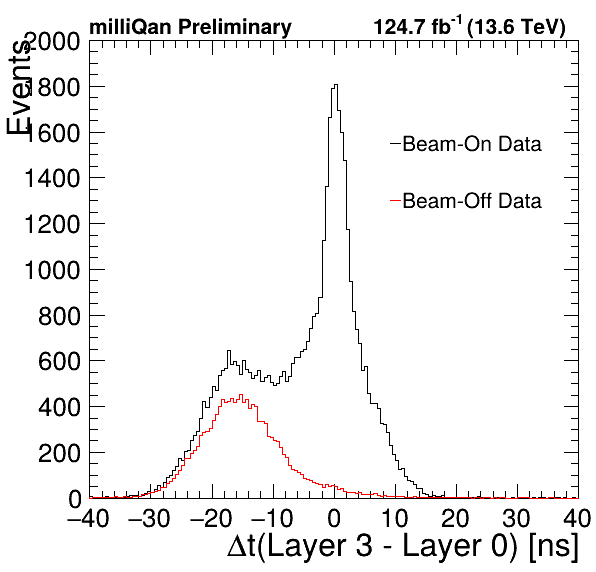

In [12]:
c1.Draw()

Info in <TCanvas::Print>: png file plots/timeDiffL20_300k.png has been created


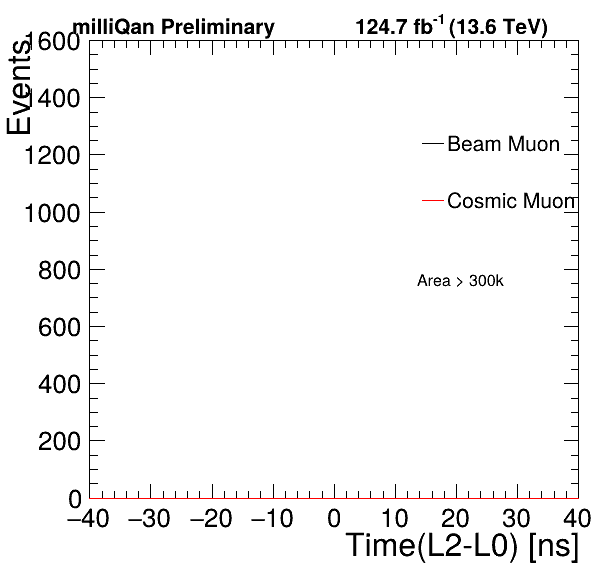

In [14]:
t_beam = f_beam.Get('h_timeDiffL20')
t_cosmic = f_cosmic.Get('h_timeDiffL20')

t_beam.SetTitle(';Time(L2-L0) [ns];Events')
t_beam.GetXaxis().SetRangeUser(-40, 40)
t_beam.GetYaxis().SetRangeUser(0, 1600)
t_cosmic.SetLineColor(r.kRed)
t_cosmic.Scale(beamOnTime/beamOffTime)

t_beam.Draw()
t_cosmic.Draw("same hist")

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.12, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.92, 0.94, "124.7 fb^{-1} (13.6 TeV)");

areaCut = r.TLatex()
areaCut.SetTextSize(0.03)
areaCut.SetTextFont(42)
areaCut.SetNDC()
areaCut.DrawLatex(0.7, 0.5, f'Area > {area}k')

l1 = r.TLegend(0.7, 0.6, 0.9, 0.8)
l1.AddEntry(t_beam, 'Beam Muon', 'l')
l1.AddEntry(t_cosmic, 'Cosmic Muon', 'l')
l1.SetBorderSize(0)
l1.Draw()

c1.Draw()
c1.SetLogy(0)
c1.SaveAs(f"plots/timeDiffL20_{area}k.png")

Info in <TCanvas::Print>: png file plots/timeDiffL10_300k.png has been created


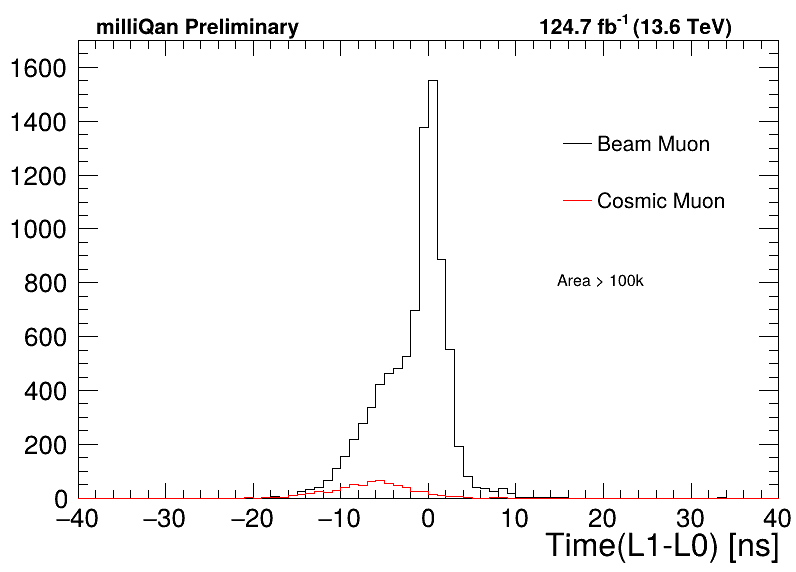

In [49]:
t_beam = f_beam.Get('h_timeDiff10')
t_cosmic = f_cosmic.Get('h_timeDiff10')

t_beam.SetTitle(';Time(L1-L0) [ns];Events')
t_beam.GetXaxis().SetRangeUser(-40, 40)
t_beam.GetYaxis().SetRangeUser(0, 1700)
t_cosmic.SetLineColor(r.kRed)
t_cosmic.Scale(beamOnTime/beamOffTime)

t_beam.Draw()
t_cosmic.Draw("same hist")

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.12, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.92, 0.94, "124.7 fb^{-1} (13.6 TeV)");

areaCut = r.TLatex()
areaCut.SetTextSize(0.03)
areaCut.SetTextFont(42)
areaCut.SetNDC()
areaCut.DrawLatex(0.7, 0.5, f'Area > {300}k')

l1 = r.TLegend(0.7, 0.6, 0.9, 0.8)
l1.AddEntry(t_beam, 'Beam Muon', 'l')
l1.AddEntry(t_cosmic, 'Cosmic Muon', 'l')
l1.SetBorderSize(0)
l1.Draw()

c1.Draw()
c1.SetLogy(0)
c1.SaveAs(f"plots/timeDiffL10_{area}k.png")

Info in <TCanvas::Print>: png file plots/timeDiffFrontBack_300k.png has been created


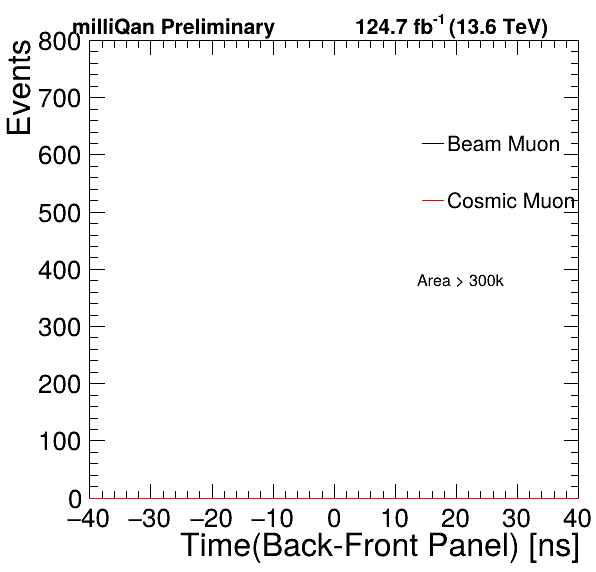

In [15]:
c1.cd()
t_beam = f_beam.Get('h_timeDiffPanel')
t_cosmic = f_cosmic.Get('h_timeDiffPanel')

t_beam.SetTitle(';Time(Back-Front Panel) [ns];Events')
t_beam.GetXaxis().SetRangeUser(-40, 40)
t_beam.GetYaxis().SetRangeUser(0, 800)
t_cosmic.SetLineColor(r.kRed)
t_cosmic.Scale(beamOnTime/beamOffTime)

t_beam.Draw()
t_cosmic.Draw("same hist")

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.12, 0.94, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.92, 0.94, "124.7 fb^{-1} (13.6 TeV)");

areaCut = r.TLatex()
areaCut.SetTextSize(0.03)
areaCut.SetTextFont(42)
areaCut.SetNDC()
areaCut.DrawLatex(0.7, 0.5, f'Area > {area}k')

l1 = r.TLegend(0.7, 0.6, 0.9, 0.8)
l1.AddEntry(t_beam, 'Beam Muon', 'l')
l1.AddEntry(t_cosmic, 'Cosmic Muon', 'l')
l1.SetBorderSize(0)
l1.Draw()

c1.Draw()
c1.SetLogy(0)
c1.SaveAs(f"plots/timeDiffFrontBack_{area}k.png")

Info in <TCanvas::Print>: png file plots/timeDiffLFront_300k.png has been created


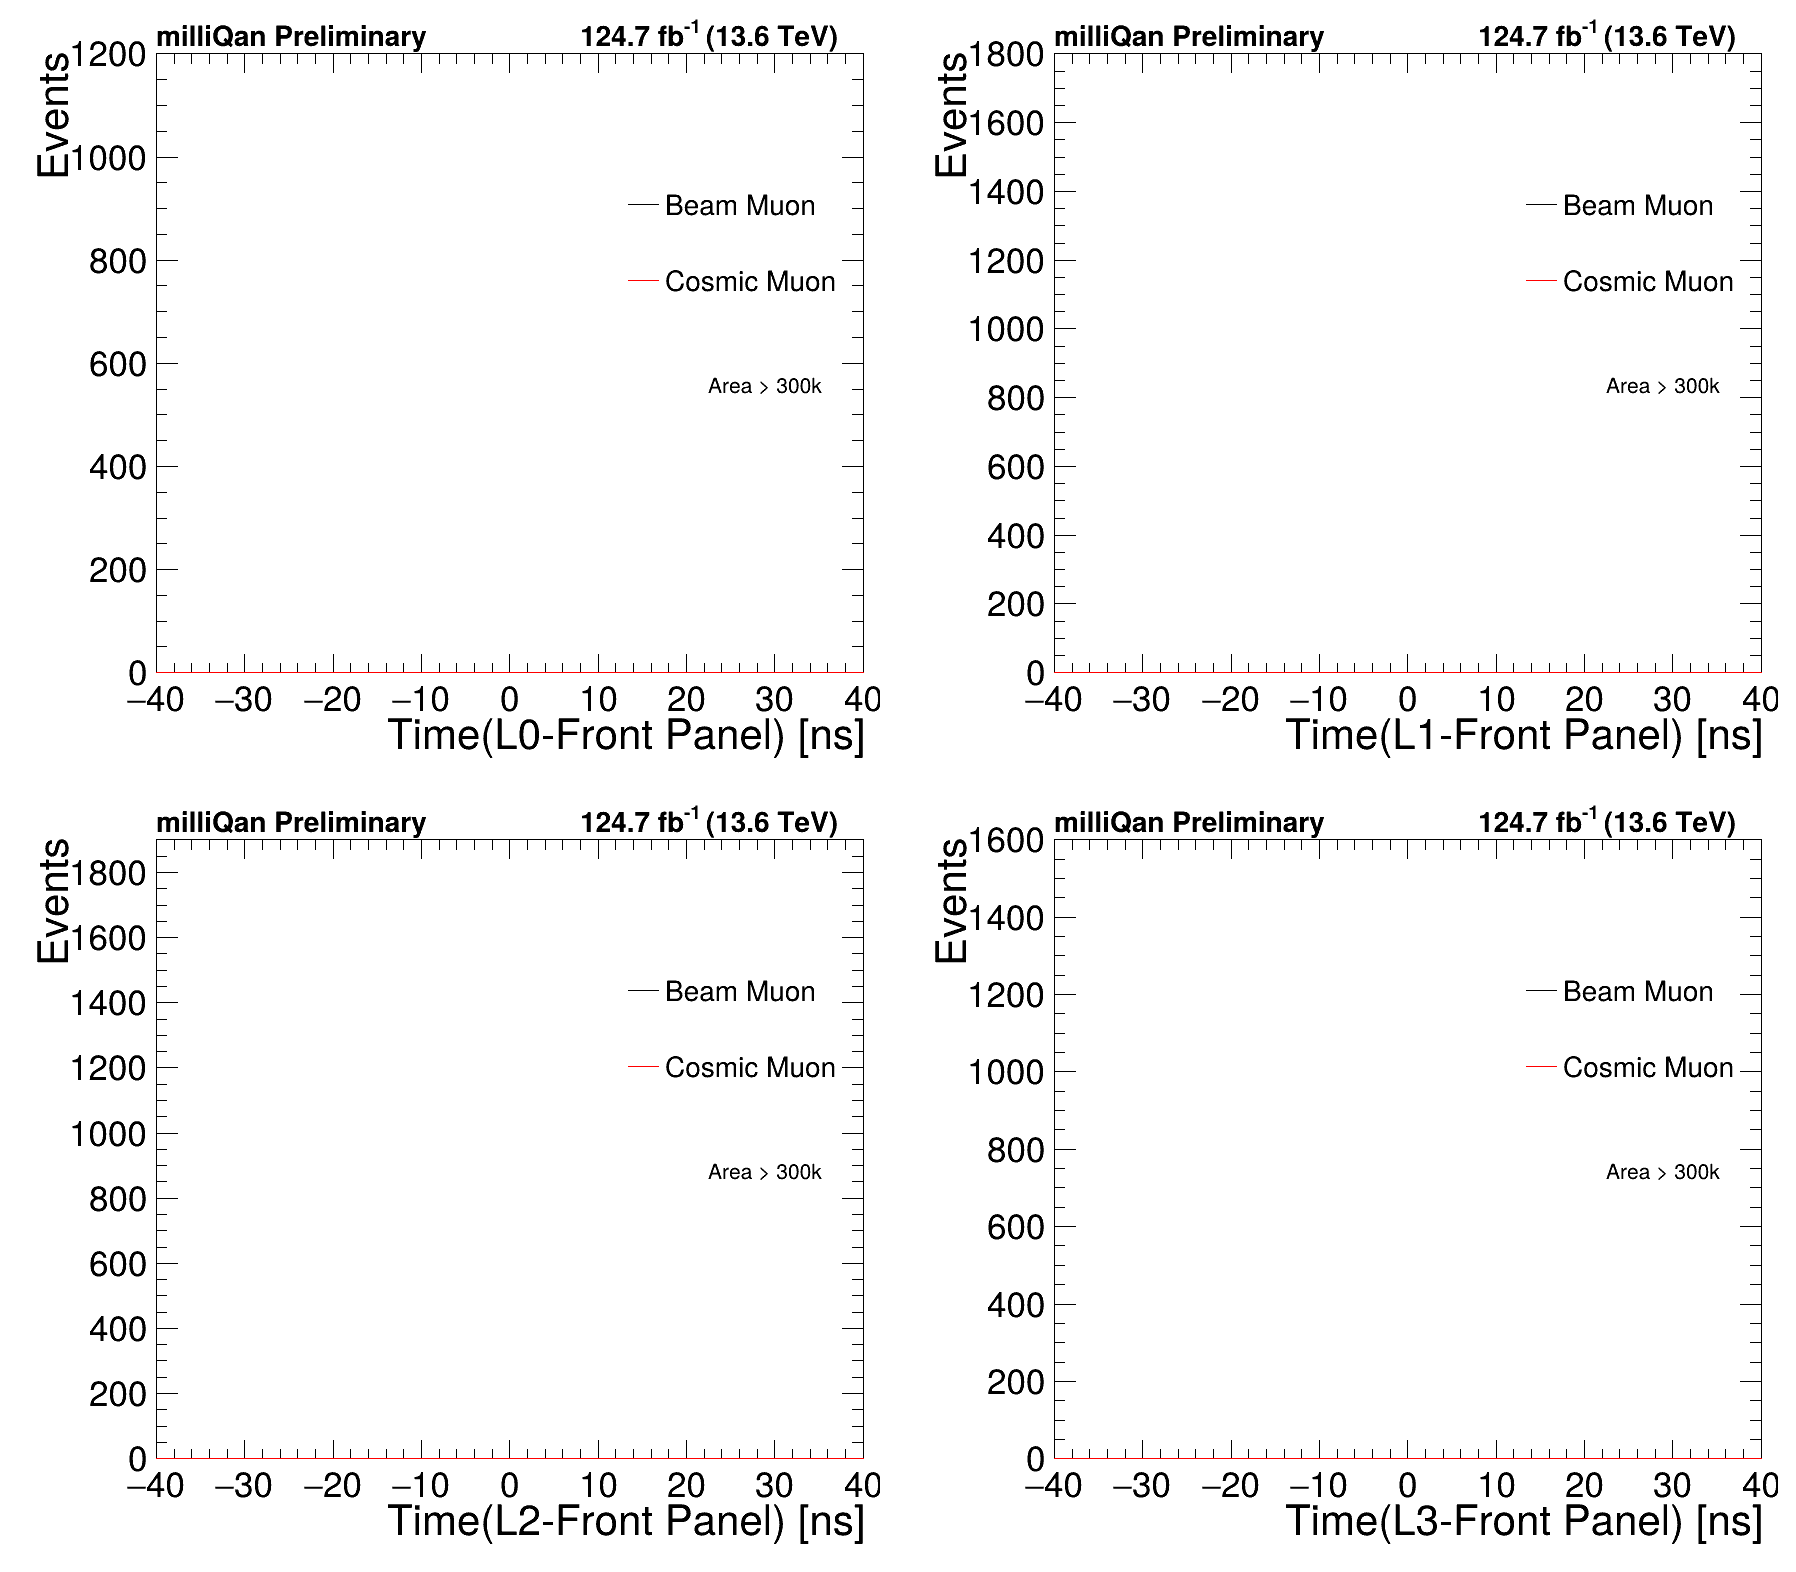

In [16]:
c2 = r.TCanvas("c2", "c2", 1800, 1600)
c2.Divide(2, 2)

t_beam0 = f_beam.Get('h_timeDiffFront0')
t_cosmic0 = f_cosmic.Get('h_timeDiffFront0')
t_beam1 = f_beam.Get('h_timeDiffFront1')
t_cosmic1 = f_cosmic.Get('h_timeDiffFront1')
t_beam2 = f_beam.Get('h_timeDiffFront2')
t_cosmic2 = f_cosmic.Get('h_timeDiffFront2')
t_beam3 = f_beam.Get('h_timeDiffFront3')
t_cosmic3 = f_cosmic.Get('h_timeDiffFront3')

t_beam0.SetTitle(';Time(L0-Front Panel) [ns];Events')
t_beam0.GetXaxis().SetRangeUser(-40, 40)
t_beam0.GetYaxis().SetRangeUser(0, 1200)
t_cosmic0.SetLineColor(r.kRed)
t_cosmic0.Scale(beamOnTime/beamOffTime)

t_beam1.SetTitle(';Time(L1-Front Panel) [ns];Events')
t_beam1.GetXaxis().SetRangeUser(-40, 40)
t_beam1.GetYaxis().SetRangeUser(0, 1800)
t_cosmic1.SetLineColor(r.kRed)
t_cosmic1.Scale(beamOnTime/beamOffTime)

t_beam2.SetTitle(';Time(L2-Front Panel) [ns];Events')
t_beam2.GetXaxis().SetRangeUser(-40, 40)
t_beam2.GetYaxis().SetRangeUser(0, 1900)
t_cosmic2.SetLineColor(r.kRed)
t_cosmic2.Scale(beamOnTime/beamOffTime)

t_beam3.SetTitle(';Time(L3-Front Panel) [ns];Events')
t_beam3.GetXaxis().SetRangeUser(-40, 40)
t_beam3.GetYaxis().SetRangeUser(0, 1600)
t_cosmic3.SetLineColor(r.kRed)
t_cosmic3.Scale(beamOnTime/beamOffTime)

c2.cd(1)
t_beam0.Draw()
t_cosmic0.Draw("same hist")

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.16, 0.96, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.95, 0.96, "124.7 fb^{-1} (13.6 TeV)");

areaCut = r.TLatex()
areaCut.SetTextSize(0.03)
areaCut.SetTextFont(42)
areaCut.SetNDC()
areaCut.DrawLatex(0.8, 0.5, f'Area > {area}k')

l1 = r.TLegend(0.7, 0.6, 0.9, 0.8)
l1.AddEntry(t_beam, 'Beam Muon', 'l')
l1.AddEntry(t_cosmic, 'Cosmic Muon', 'l')
l1.SetBorderSize(0)
l1.Draw()

c2.cd(2)
t_beam1.Draw()
t_cosmic1.Draw("same hist")
l1.Draw()
areaCut.DrawLatex(0.8, 0.5, f'Area > {area}k')
textRun.DrawLatex(0.95, 0.96, "124.7 fb^{-1} (13.6 TeV)");
expName.DrawLatex(0.16, 0.96, "milliQan Preliminary");

c2.cd(3)
t_beam2.Draw()
t_cosmic2.Draw("same hist")
l1.Draw()
areaCut.DrawLatex(0.8, 0.5, f'Area > {area}k')
textRun.DrawLatex(0.95, 0.96, "124.7 fb^{-1} (13.6 TeV)");
expName.DrawLatex(0.16, 0.96, "milliQan Preliminary");

c2.cd(4)
t_beam3.Draw()
t_cosmic3.Draw("same hist")
l1.Draw()
areaCut.DrawLatex(0.8, 0.5, f'Area > {area}k')
textRun.DrawLatex(0.95, 0.96, "124.7 fb^{-1} (13.6 TeV)");
expName.DrawLatex(0.16, 0.96, "milliQan Preliminary");

c2.Draw()
c2.SaveAs(f"plots/timeDiffLFront_{area}k.png")

In [185]:


for filename in os.listdir('/eos/experiment/milliqan/skims/cosmic/'):
    if not filename.endswith('.root'): continue
    if not 'v36' in filename: continue
    if not 'beamOn' in filename: continue
    fin = r.TFile.Open('/eos/experiment/milliqan/skims/cosmic/'+filename, 'READ')
    lumi = fin.Get('luminosity')
    print(filename, lumi)
    fin.Close()

MilliQan_Run1000_v36_cosmic_beamOn_medium.root Name: luminosity Title: 5472.296615677699
MilliQan_Run1100_v36_cosmic_beamOn_medium.root Name: luminosity Title: 2633.5180107168
MilliQan_Run1400_v36_cosmic_beamOn_medium.root Name: luminosity Title: 0.000314274
MilliQan_Run1500_v36_cosmic_beamOn_medium.root Name: luminosity Title: 24527.321702145702
MilliQan_Run1600_v36_cosmic_beamOn_medium.root Name: luminosity Title: 29316.5446162555
MilliQan_Run1700_v36_cosmic_beamOn_medium.root Name: luminosity Title: 49464.594903007805
MilliQan_Run1800_v36_cosmic_beamOn_medium.root Name: luminosity Title: 5281.713168181001
MilliQan_Run1900_v36_cosmic_beamOn_medium.root Name: luminosity Title: 8031.435388555201


In [179]:
fin = r.TFile.Open('/eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root')
fin.ls()

TNetXNGFile**		root://eospublic.cern.ch//eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root	
 TNetXNGFile*		root://eospublic.cern.ch//eos/experiment/milliqan/skims/beam/MilliQan_Run1800_v35_beam_beamOn_tight.root	
  KEY: TTree	t;1	t


In [186]:
0.000314274+24527.321702145702+29316.5446162555+49464.594903007805

103308.461535683

In [47]:
fin = r.TFile.Open('../backgroundEstimation/beamMuonArea_800kFrontBackRequired.root')

h_L3 = fin.Get('h_nPEL3')
h_front = fin.Get('h_nPEFront')

h_L3.Scale(1/h_L3.GetEntries())
h_front.Scale(1/h_front.GetEntries())


Info in <TCanvas::Print>: png file panelVsBarNPE.png has been created


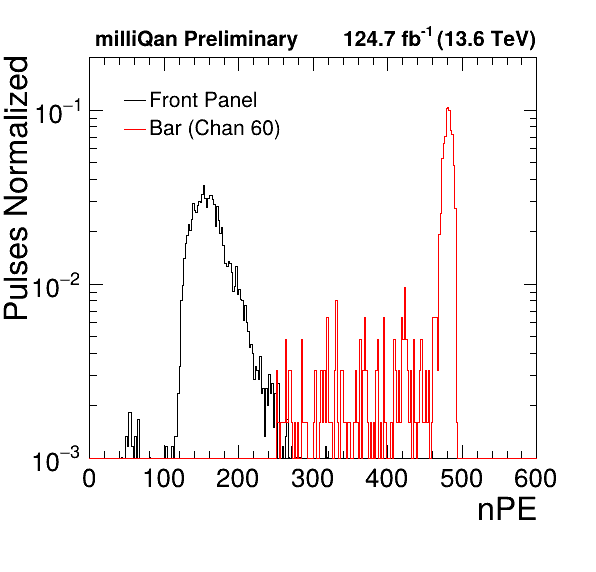

In [60]:

h_front.Draw("hist")
h_front.SetTitle(';nPE;Pulses Normalized')
h_front.GetXaxis().SetRangeUser(0, 600)
h_front.GetYaxis().SetRangeUser(1e-3, 0.2)
h_L3.Draw("hist same")

r.gPad.SetRightMargin(0.1)
r.gPad.SetLeftMargin(0.15)
r.gPad.SetBottomMargin(0.2)
r.gPad.SetTopMargin(0.1)
h_front.GetYaxis().SetTitleOffset(1.3)

expName = r.TLatex()
expName.SetNDC()
expName.SetTextSize(0.04);
expName.DrawLatex(0.16, 0.92, "milliQan Preliminary");

textRun = r.TLatex()
textRun.SetNDC()
textRun.SetTextSize(0.04)
textRun.SetTextAlign(31)
textRun.DrawLatex(0.9, 0.92, "124.7 fb^{-1} (13.6 TeV)");

l1 = r.TLegend(0.2, 0.75, 0.4, 0.85)
l1.AddEntry(h_front, 'Front Panel', 'l')
l1.AddEntry(h_L3, 'Bar (Chan 60)', 'l')
l1.Draw()

h_L3.SetLineColor(r.kRed)
c1.Draw()
c1.SetLogy()
c1.SaveAs('panelVsBarNPE.png')